①チェック
②欠損値処理
③ラベルエンコード
④heatmapなどで特徴量選定or生成
⑤モデル生成

##### 目的変数
target = "Salary"
 
##### Xは目的変数以外全て
X = df.loc[:, df.columns!=target]
##### yは目的変数のみ
y = df[target]
##### hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [865]:
#data analysis and wranding
import numpy as np
import pandas as pd
import random as rnd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# change style
sns.set()

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


from scipy.stats import skew
from scipy import stats
from scipy.stats import norm, skew #for some statistics

#ignore annoying warning (from sklearn and seaborn)
import warnings
def ignore_warn(*arg, **kwargs):
    pass
warnings.warn = ignore_warn

#Limiting floats output to 3 decimal points
pd.set_option("display.float_format", lambda x: "{: .3f}".format(x))
# expand the number of displayed columns
pd.set_option('display.max_columns', None, 'display.max_rows', None)

train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
gender_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

# データ削除時のための対応
train_df["TrainFlag"] = True
test_df["TrainFlag"] = False
data = pd.concat([train_df, test_df], sort=False, ignore_index=True)

In [866]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000,2919.000,2433.000,2919.000,2919.000,2919.000,2919.000,2919.000,2896.000,2918.000,2918.000,2918.000,2918.000,2919.000,2919.000,2919.000,2919.000,2917.000,2917.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2760.000,2918.000,2918.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,1460.000
mean,1460.000,57.138,69.306,10168.114,6.089,5.565,1971.313,1984.264,102.201,441.423,49.582,560.772,1051.778,1159.582,336.484,4.694,1500.760,0.430,0.061,1.568,0.380,2.860,1.045,6.452,0.597,1978.113,1.767,472.875,93.710,47.487,23.098,2.602,16.062,2.252,50.826,6.213,2007.793,180921.196
std,842.787,42.518,23.345,7886.996,1.410,1.113,30.291,20.894,179.334,455.611,169.206,439.544,440.766,392.362,428.701,46.397,506.051,0.525,0.246,0.553,0.503,0.823,0.214,1.569,0.646,25.574,0.762,215.395,126.527,67.575,64.244,25.188,56.184,35.664,567.402,2.715,1.315,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,1895.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,730.500,20.000,59.000,7478.000,5.000,5.000,1953.500,1965.000,0.000,0.000,0.000,220.000,793.000,876.000,0.000,0.000,1126.000,0.000,0.000,1.000,0.000,2.000,1.000,5.000,0.000,1960.000,1.000,320.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,2007.000,129975.000
50%,1460.000,50.000,68.000,9453.000,6.000,5.000,1973.000,1993.000,0.000,368.500,0.000,467.000,989.500,1082.000,0.000,0.000,1444.000,0.000,0.000,2.000,0.000,3.000,1.000,6.000,1.000,1979.000,2.000,480.000,0.000,26.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,2189.500,70.000,80.000,11570.000,7.000,6.000,2001.000,2004.000,164.000,733.000,0.000,805.500,1302.000,1387.500,704.000,0.000,1743.500,1.000,0.000,2.000,1.000,3.000,1.000,7.000,1.000,2002.000,2.000,576.000,168.000,70.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,2919.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1526.000,2336.000,6110.000,5095.000,2065.000,1064.000,5642.000,3.000,2.000,4.000,2.000,8.000,3.000,15.000,4.000,2207.000,5.000,1488.000,1424.000,742.000,1012.000,508.000,576.000,800.000,17000.000,12.000,2010.000,755000.000


In [867]:
train_df.describe(include=["O"])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [868]:
data.head()

# check the missing data 3
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(40)

,Total,Percent
PoolQC,2909,0.997
MiscFeature,2814,0.964
Alley,2721,0.932
Fence,2348,0.804
SalePrice,1459,0.500
FireplaceQu,1420,0.486
LotFrontage,486,0.166
GarageYrBlt,159,0.054
GarageQual,159,0.054
GarageFinish,159,0.054


In [869]:
# descriptive statistics summary
data["SalePrice"].describe()

count      1460.000
mean     180921.196
std       79442.503
min       34900.000
25%      129975.000
50%      163000.000
75%      214000.000
max      755000.000
Name: SalePrice, dtype: float64

## 前処理

In [870]:
data["PoolQC"] = data["PoolQC"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data["Fence"] = data["Fence"].fillna("None")
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
data = data.drop(['Utilities'], axis=1)

data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
data["Functional"] = data["Functional"].fillna("Typ")
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
data['MSSubClass'] = data['MSSubClass'].fillna("None")

##### Transforming some numerical variables that are really categorical

In [871]:
#MSSubClass=The building class
data['MSSubClass'] = data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
data['OverallCond'] = data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [872]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

# shape        
print('Shape all_data: {}'.format(data.shape))

Shape all_data: (2919, 81)


Skewness: 1.882876
Kurtosis: 6.536282


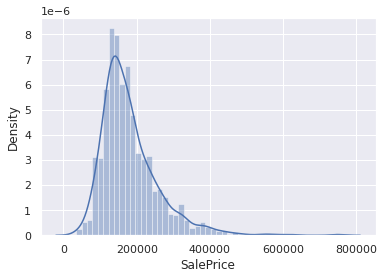

In [873]:
sns.distplot(data["SalePrice"])

#skewness（歪度） and kurtosis(尖度)
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

## Data processing

Outliers(外れ値)

<AxesSubplot:>

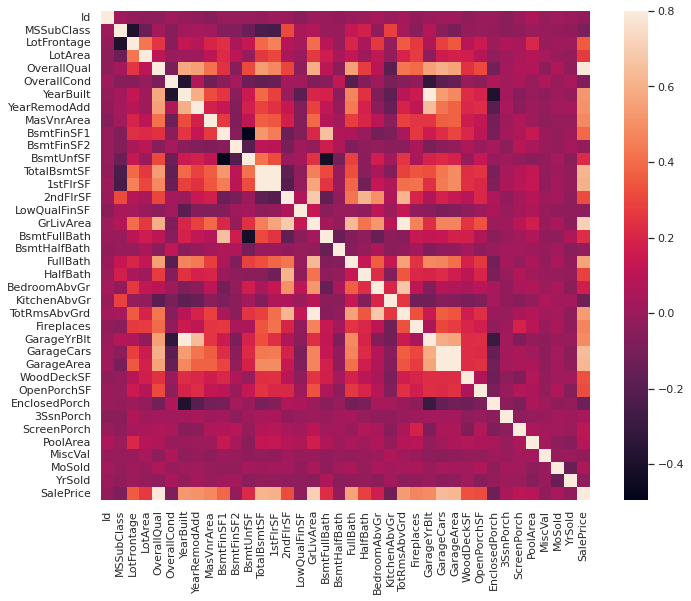

In [874]:
corr = train_df.drop("TrainFlag", axis=1).corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data=corr, vmax=.8, square=True)

‣「OverallQual」、「GrLivArea」、「TotalBsmtSF」は「SalePrice」と強い相関がある。

‣「GarageCars」 と 「GarageArea」 も、最も強い相関を持つ変数の一つです。しかし、前回のサブポイントで説明したように、ガレージに収まる車の台数は、ガレージ面積の結果である。

‣「GarageCars」と「GarageArea」は、双子の兄弟のようなものである。見分けがつかなくなります。したがって、我々の分析ではこれらの変数のうちの1つだけが必要です（'SalePrice'との相関がより高いので'GarageCars'はそのままでもよいでしょう）。

‣「TotalBsmtSF」 と 「1stFloor」 は、双子の兄弟のように見えます。「TotalBsmtSF」は、最初の推測が正しかったということで、そのままにしておきます（「So... What can we expect?」を再読してください）。
FullBath」？本当に？
TotRmsAbvGrd」と「GrLivArea」、またしても双子の兄弟。このデータセット、チェルノブイリのものなのか？
ああ...「YearBuilt」... YearBuilt'は'SalePrice'と若干の相関があるようです。正直、'YearBuilt'のことを考えると、ちょっと時系列分析をした方がいいような気がしてくるので、怖いです。これは宿題として残しておきます。
それでは、散布図に進みましょう。

www.DeepL.com/Translator（無料版）で翻訳しました。

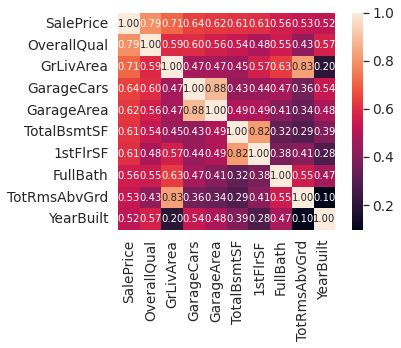

In [875]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(data=cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

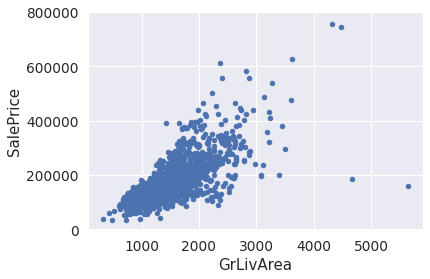

In [876]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
tmp_data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
tmp_data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

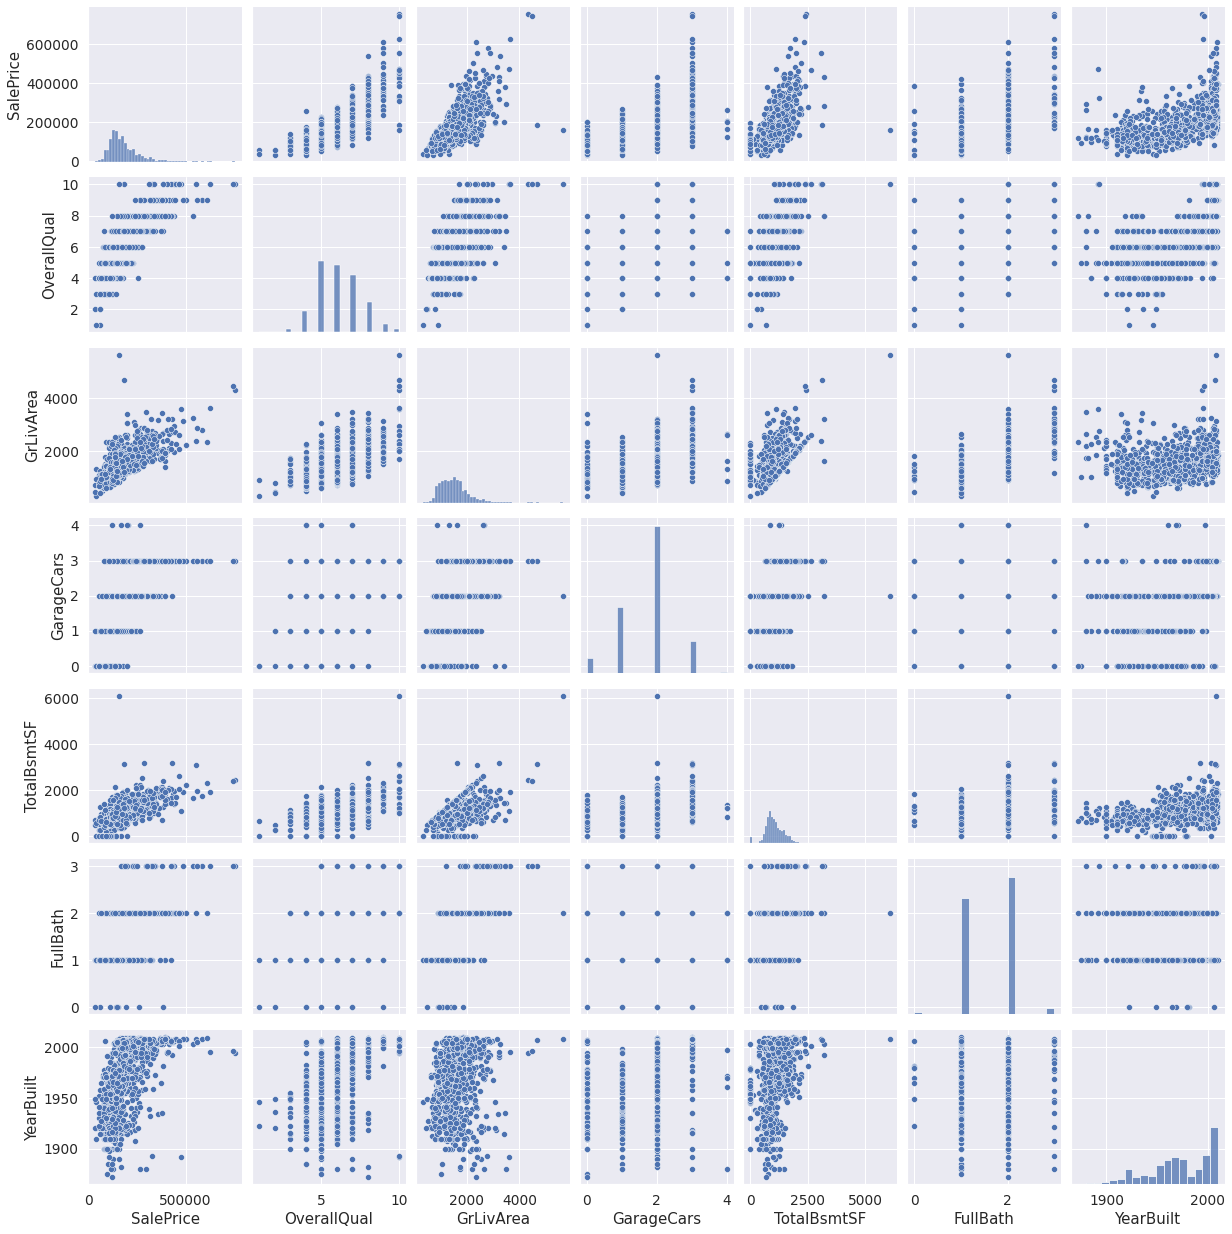

In [877]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data=train_df[cols], size=2.5)
plt.show()

興味深い図の1つは、「TotalBsmtSF」と「GrLiveArea」の間の図です。この図では、点が直線的な線を描いており、それがほとんど境界線のように機能しているのがわかる。この線は、ほとんど境界線のようなもので、大多数のドットがこの線より下にあるのは、まったく理にかなっている。地下室の面積は、地上の居住面積と同じにすることができますが、地上の居住面積より大きい地下室は期待できません（バンカーを買おうとしている場合は別ですが）。 

「SalePrice」と「YearBuilt」に関するプロットもまた、私たちに考えさせるものである。点群」の下部には、ほとんど指数関数に見えるものがある。また、「点の雲」の上限にもこれと同じ傾向が見られる（さらに創造力を働かせよう）。また、過去数年間の点の集合がこの限界より上に留まる傾向があることにも注目してください（私は、現在、価格がより速く上昇していると言いたかっただけなのです）。 

それでは、不足しているもの、つまり欠損データについて考えてみましょう。

## 欠損値補完

In [878]:
# check the missing data →train
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data_train = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data_train.head(40)

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageType,81,0.055
GarageYrBlt,81,0.055
GarageCond,81,0.055
GarageQual,81,0.055


In [879]:
# check the missing data →data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(40)
print(len(data.loc[data["TrainFlag"] == False]))
print(len(test_df), len(data[data["TrainFlag"] == False]))

1459
1459 1459


データの15%以上が欠損している場合、対応する変数を削除して、存在しなかったことにするべきだと考えます。つまり、このような場合、欠損データを埋めるためのトリックは試さないということです。これによると、削除すべき変数の集合（たとえば、'PoolQC'、'MiscFeature'、'Alley'など）が存在します。ポイントは、このデータを見逃すかどうかということです。私はそうは思いません。これらの変数のほとんどは、家を買うときに考えるような側面ではないので、どれもあまり重要ではなさそうです（もしかしたら、それがデータが欠落している理由かもしれませんね）。さらに、変数をよく見ると、'PoolQC', 'MiscFeature', 'FireplaceQu'などの変数は、外れ値の強い候補であると言えますので、それらを削除してもよいことになります。

残りのケースに関して言えば、'GarageX' 変数は、同じ数の欠損データを持っていることがわかります。私は、missing dataが同じオブザベーションの集合を指していることに賭けます（ただし、私はそれをチェックしません; それはちょうど5%で、我々は20 in 5の問題を費やすべきではありません）。
  の問題に20を費やすべきではありません)。ガレージに関する最も重要な情報は 'GarageCars' によって表現されるので、そして我々がちょうど5%の欠損データについて話していることを考えると、言及した 'GarageX' 変数を削除します。BsmtX'変数についても同じロジックが適用されます。

MasVnrArea' と 'MasVnrType' については、これらの変数は必須ではないと考えることができます。さらに、それらはすでに考慮されている 'YearBuilt' および 'OverallQual' と強い相関を持っています。したがって、'MasVnrArea' と 'MasVnrType' を削除しても、情報を失うことはないでしょう。

最後に、'Electrical'に1つの欠損オブザベーションがあります。それは1つのオブザベーションなので、このオブザベーションを削除して、変数を保持することにします。

要約すると、欠損データを取り扱うために、変数 'Electrical' を除いて、欠損データを持つすべての変数を削除します。Electrical' では、欠損データのあるオブザベーションを削除するだけです。

In [880]:
#dealing with missing data
#train_df = train_df.drop((missing_data_train[missing_data_train['Total'] > 1]).index, axis=1)
#data = data.drop((missing_data_train[missing_data_train['Total'] > 1]).index, axis=1)

#train_df = train_df.drop(train_df.loc[train_df['Electrical'].isnull()].index)
#data = data.drop(data.loc[data['Electrical'].isnull()].index)

#train_df.isnull().sum().max() #just checking that there's no missing data missing...

In [881]:
#standardizing data
stdsc = StandardScaler()
saleprice_scaled = stdsc.fit_transform(train_df['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


### 二変量解析（Bivariate analysis）

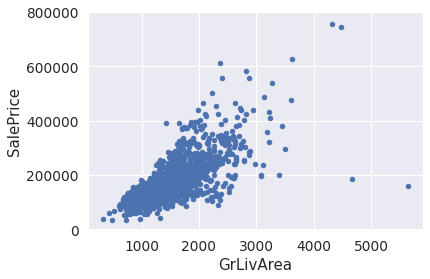

In [882]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
tmp_data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
tmp_data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [883]:
print(len(test_df), len(data[data["TrainFlag"] == False]))
print(len(train_df), len(data[data["TrainFlag"] == True]))
print(len(data))
print(data[(data['Id'] == 1299) & (data["TrainFlag"] == True)].index)
print(data[(data['Id'] == 524) & (data["TrainFlag"] == True)].index)

1459 1459
1460 1460
2919
Int64Index([1298], dtype='int64')
Int64Index([523], dtype='int64')


In [884]:
#deleting points
train_df.sort_values(by = 'GrLivArea', ascending = False)[:2]
train_df = train_df.drop(train_df[train_df['Id'] == 1299].index)
data = data.drop(data[(data['Id'] == 1299) & (data["TrainFlag"] == True)].index)

train_df = train_df.drop(train_df[train_df['Id'] == 524].index)
data = data.drop(data[(data['Id'] == 524) & (data["TrainFlag"] == True)].index)

In [885]:
print(len(test_df), len(data[data["TrainFlag"] == False]))
print(len(train_df), len(data[data["TrainFlag"] == True]))
print(len(data))

1459 1459
1458 1458
2917


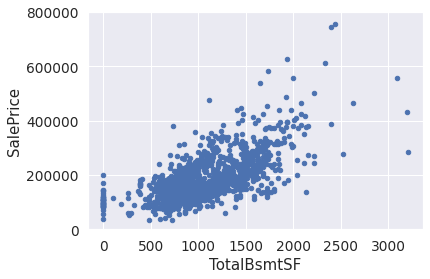

In [886]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
tmp_data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
tmp_data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [887]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Target Variable


 mu = 180932.92 and sigma = 79467.79



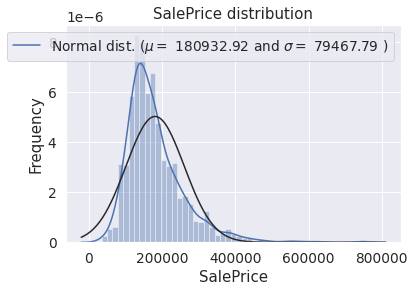

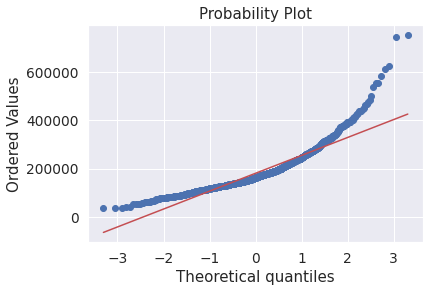

In [888]:
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

In [889]:
print(len(test_df), len(data[data["TrainFlag"] == False]))

1459 1459



 mu = 12.02 and sigma = 0.40



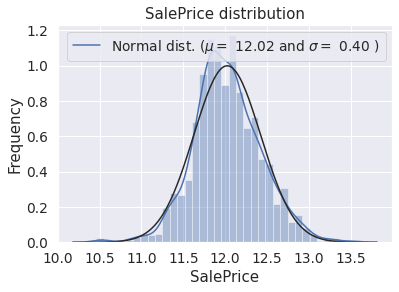

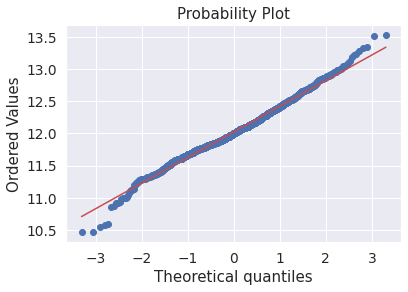

In [890]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
data.loc[data["TrainFlag"] == True, "SalePrice"] = train_df["SalePrice"]

#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

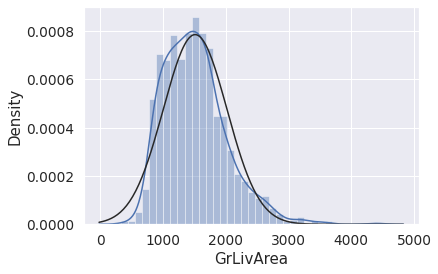

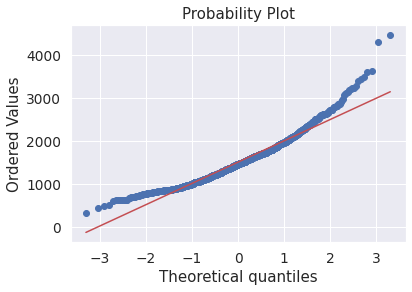

In [891]:
#histogram and normal probability plot
sns.distplot(train_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['GrLivArea'], plot=plt)

In [892]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df['GrLivArea'] = np.log1p(train_df['GrLivArea'])
data['GrLivArea'] = np.log1p(data['GrLivArea'])

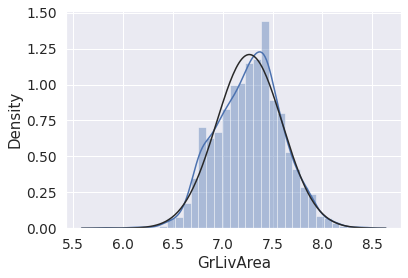

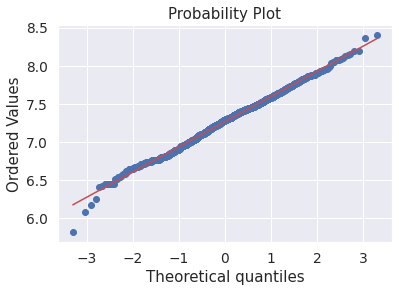

In [893]:
#transformed histogram and normal probability plot
sns.distplot(train_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['GrLivArea'], plot=plt)

In [894]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
train_df['HasBsmt'] = pd.Series(len(train_df['TotalBsmtSF']), index=train_df.index)
data['HasBsmt'] = pd.Series(len(data['TotalBsmtSF']), index=data.index)
train_df['HasBsmt'] = 0
data['HasBsmt'] = 0 
train_df.loc[train_df['TotalBsmtSF']>0,'HasBsmt'] = 1
data.loc[data['TotalBsmtSF']>0, 'HasBsmt'] = 1

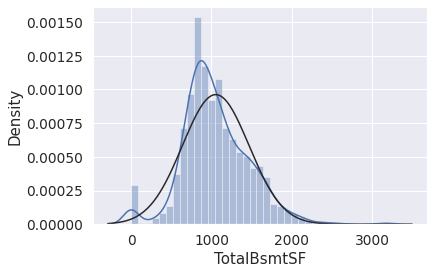

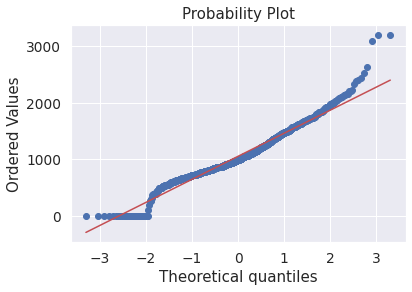

In [895]:
#histogram and normal probability plot
sns.distplot(train_df['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['TotalBsmtSF'], plot=plt)

値0は対数変換を行うことを許さないので、大きな問題です。ここで対数変換を適用するために、我々は、地下室があるかないかの効果を得ることができる変数（バイナリ変数）を作成します。そして、値0を持つものを無視して、すべての非ゼロのオブザベーションに対数変換を行います。この方法で、地下室を持つか持たないかの効果を失うことなく、データを変換することができます。

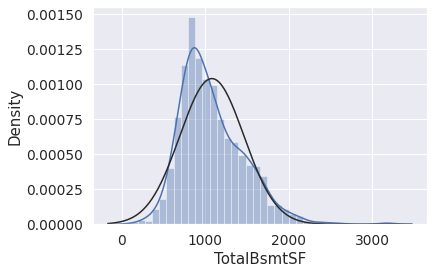

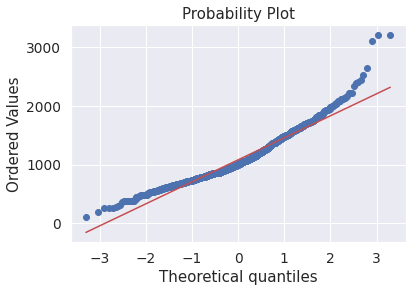

In [896]:
#histogram and normal probability plot
sns.distplot(train_df[train_df['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df[train_df['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

2つの計量変数のホモソデシティを検定するには、グラフを使うのが一番良い方法である。均等な分散からの逸脱は、円錐（グラフの片側で小さな分散、反対側で大きな分散）または菱形（分布の中心で多くの点）のような形状で示されます。

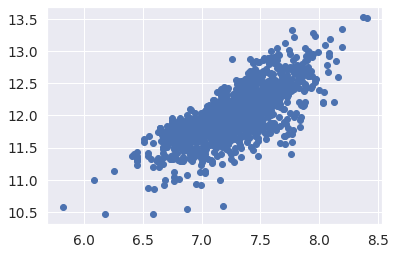

In [897]:
#scatter plot
plt.scatter(train_df['GrLivArea'], train_df['SalePrice']);

In [898]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckS

In [899]:
cols = ["Id",'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','TrainFlag']
data = data[cols]
freq_cars = data["GarageCars"].dropna().mode()[0]
data["GarageCars"] = data["GarageCars"].fillna(freq_cars)
data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(data['TotalBsmtSF'].dropna().mean())
data['SalePrice'] = data['SalePrice'].fillna(data['SalePrice'].dropna().mean())
data = pd.get_dummies(data)
data.head()

,Id,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,TrainFlag
0,1,12.248,7,7.445,2.000,856.000,2,2003,True
1,2,12.109,6,7.141,2.000,1262.000,2,1976,True
2,3,12.317,7,7.488,2.000,920.000,2,2001,True
3,4,11.849,7,7.449,3.000,756.000,1,1915,True
4,5,12.429,8,7.696,3.000,1145.000,2,2000,True


In [900]:
# データ分割
train_df = data[data["TrainFlag"] == True]
test_df = data[data["TrainFlag"] == False]

target = 'SalePrice'
# traindata　生成
y_train = train_df[target]
X_train = train_df.loc[:, train_df.columns!=target].drop(['Id', 'TrainFlag'], axis=1)
X_test = test_df.loc[:, test_df.columns!=target].drop(['Id', 'TrainFlag'], axis=1)
print(len(X_test), len(test_df))

1459 1459


In [901]:
print(X_train.shape, y_train.shape)

(1458, 6) (1458,)


In [902]:
# 線形回帰モデルを使う
lr = LinearRegression()
# trainデータを使って学習する
lr.fit(X_train, y_train)

def adjusted(score, n_sample, n_features):
    adjusted_score = 1 - (1 - score) * ((n_sample - 1) / (n_sample - n_features - 1))
    return adjusted_score

print('adjusted R^2')
print('train: %.3f' % adjusted(lr.score(X_train, y_train), len(y_train),X_train.shape[1]))

#y_pred = np.expm1(lr.predict(X_test))
y_pred = lr.predict(X_test)
print(len(X_test), len(test_df))

adjusted R^2
train: 0.844
1459 1459


In [903]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## BaseModel

・ lasso regression

このモデルは外れ値に対して非常に敏感である可能性があります。そこで、外れ値に対してよりロバストにする必要がある。そのためにsklearnのRobustscaler()メソッドをパイプラインで使用する。

In [904]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1584 (0.0047)



Elastic Net Regression

again made robust to outliers

In [905]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1584 (0.0047)



Kernel Ridge Regression :

In [906]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.85662e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.39021e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.81397e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.88646e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning

Kernel Ridge score: 0.1548 (0.0043)



XGBoost

In [907]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1563 (0.0065)



LightGBM :

In [908]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1583 (0.0070)



In [909]:
model_lgb.fit(X_train, y_train)
y_pred_lbg = model_lgb.predict(X_test)
y_lgb_pred = np.expm1(y_pred_lbg)
print(len(y_train), len(X_train) ,len(y_lgb_pred),len(test_df["Id"]))

1458 1458 1459 1459


In [910]:
sub = gender_submission
sub['SalePrice'] = list(map(int, y_lgb_pred))
sub.to_csv("/kaggle/working/submission.csv", index=False)
sub.head()

,Id,SalePrice
0,1461,124116
1,1462,152941
2,1463,169292
3,1464,177722
4,1465,192300
